In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e22/sample_submission.csv
/kaggle/input/playground-series-s3e22/train.csv
/kaggle/input/playground-series-s3e22/test.csv


## 导入必要的库

In [17]:

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from colorama import Fore, Style, init

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.feature_selection import mutual_info_classif
from scipy import stats

from sklearn.decomposition import PCA

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

## 读取数据

In [4]:
train_df = pd.read_csv('/kaggle/input/playground-series-s3e22/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s3e22/test.csv')
train_df = train_df.set_index("id")
test_df = test_df.set_index("id")

## 常用函数

In [5]:
def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    print(style + color + text + style)

# 字典编码函数  排序映射赋值（有序离散object处理）
def change_object_cols(se):
    value = se.unique().tolist()
    value.sort()
    return se.map(pd.Series(range(len(value),index=value))).values
# 多变量分析  将两个变量融合进而分析
def combine_feature(df):
    cols = df.columns
    feature1 = df[cols[0]].astype(str).values.tolist()
    feature2 = df[cols[1]].astype(str).values.tolist()
    return pd.Series([feature1[i] + '&' + feature2[i] for i in range(df.shape[0])])

## EDA

In [6]:
# Train
PrintColor(f"\nTrain set head", color = Fore.BLUE)
display(train_df.head(5).style.format(precision = 3))
PrintColor(f"\nTrain set description", color = Fore.BLUE)
display(train_df.describe(percentiles= [0.05, 0.25, 0.50, 0.75, 0.9, 0.95, 0.99]).transpose().
                            drop(columns = ['count'], errors = 'ignore').
                            style.format(formatter = '{:,.2f}').
                            background_gradient(cmap = 'Purples'))
PrintColor(f"\nTrain set Information", color = Fore.BLUE)
display(train_df.info())

feature_columns = train_df.columns[:-1]
target = train_df.columns[-1]

# Test
PrintColor(f"\nTest set head", color = Fore.BLUE)
display(test_df.head(5).style.format(precision = 3))
PrintColor(f"\Test set description", color = Fore.BLUE)
display(test_df.describe(percentiles= [0.05, 0.25, 0.50, 0.75, 0.9, 0.95, 0.99]).transpose().
                            drop(columns = ['count'], errors = 'ignore').
                            style.format(formatter = '{:,.2f}').
                            background_gradient(cmap = 'Purples'))
PrintColor(f"\Test set Information", color = Fore.BLUE)
display(test_df.info())


Train set head


,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,yes,adult,530001,38.100,132.000,24.000,cool,reduced,dark_cyanotic,more_3_sec,depressed,absent,slight,slight,less_1_liter,6.500,decreased,distend_small,57.000,8.500,serosanguious,3.400,yes,2209,0,0,no,died
1,yes,adult,533836,37.500,88.000,12.000,cool,normal,pale_cyanotic,more_3_sec,mild_pain,absent,moderate,none,more_1_liter,2.000,absent,distend_small,33.000,64.000,serosanguious,2.000,yes,2208,0,0,no,euthanized
2,yes,adult,529812,38.300,120.000,28.000,cool,reduced,pale_pink,less_3_sec,extreme_pain,hypomotile,moderate,slight,none,3.500,nan,distend_large,37.000,6.400,serosanguious,3.400,yes,5124,0,0,no,lived
3,yes,adult,5262541,37.100,72.000,30.000,cold,reduced,pale_pink,more_3_sec,mild_pain,hypomotile,moderate,slight,more_1_liter,2.000,decreased,distend_small,53.000,7.000,cloudy,3.900,yes,2208,0,0,yes,lived
4,no,adult,5299629,38.000,52.000,48.000,normal,normal,normal_pink,less_3_sec,alert,hypomotile,none,slight,less_1_liter,7.000,normal,normal,47.000,7.300,cloudy,2.600,no,0,0,0,yes,lived



Train set description


,mean,std,min,5%,25%,50%,75%,90%,95%,99%,max
hospital_number,"954,500.40","1,356,403.14","521,399.00","527,563.00","528,800.00","529,777.00","534,145.00","535,330.00","5,290,409.00","5,299,603.00","5,305,129.00"
rectal_temp,38.20,0.79,35.40,37.10,37.80,38.20,38.60,39.30,39.50,40.30,40.80
pulse,79.57,29.11,30.00,42.00,53.00,76.00,100.00,114.00,129.00,164.00,184.00
respiratory_rate,30.05,16.45,8.00,12.00,18.00,28.00,36.00,48.00,60.00,90.00,96.00
nasogastric_reflux_ph,4.38,1.94,1.00,2.00,2.00,4.50,6.00,7.00,7.00,7.50,7.50
packed_cell_volume,49.60,10.54,23.00,34.70,43.00,48.00,57.00,66.00,69.00,75.00,75.00
total_protein,21.39,26.68,3.50,5.87,6.60,7.50,9.10,74.00,80.00,82.00,89.00
abdomo_protein,3.29,1.59,0.10,1.00,2.00,3.00,4.30,5.20,6.50,8.00,10.10
lesion_1,"3,832.50","5,436.73",0.00,0.00,"2,205.00","2,209.00","3,205.00","7,111.00","8,700.00","31,110.00","41,110.00"
lesion_2,14.61,193.71,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"3,112.00"



Train set Information
<class 'pandas.core.frame.DataFrame'>
Index: 1235 entries, 0 to 1234
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                1235 non-null   object 
 1   age                    1235 non-null   object 
 2   hospital_number        1235 non-null   int64  
 3   rectal_temp            1235 non-null   float64
 4   pulse                  1235 non-null   float64
 5   respiratory_rate       1235 non-null   float64
 6   temp_of_extremities    1196 non-null   object 
 7   peripheral_pulse       1175 non-null   object 
 8   mucous_membrane        1214 non-null   object 
 9   capillary_refill_time  1229 non-null   object 
 10  pain                   1191 non-null   object 
 11  peristalsis            1215 non-null   object 
 12  abdominal_distention   1212 non-null   object 
 13  nasogastric_tube       1155 non-null   object 
 14  nasogastric_reflux     1214 non-null  

None


Test set head


,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
id,,,,,,,,,,,,,,,,,,,,,,,,,,,
1235,no,adult,534053,38.600,40.000,20.000,normal,normal,normal_pink,less_3_sec,mild_pain,hypomotile,slight,none,none,7.000,normal,distend_small,42.000,7.500,clear,2.300,no,0,0,0,no
1236,yes,adult,528469,38.200,112.000,48.000,cool,reduced,bright_pink,more_3_sec,depressed,hypomotile,moderate,slight,none,3.500,decreased,distend_small,44.000,6.000,serosanguious,2.600,no,2208,0,0,yes
1237,yes,adult,528178,37.700,66.000,12.000,cool,normal,bright_red,less_3_sec,mild_pain,hypomotile,slight,slight,none,3.000,normal,distend_small,31.500,6.000,cloudy,1.600,yes,2205,0,0,yes
1238,no,adult,534784,37.100,88.000,20.000,cool,reduced,pale_cyanotic,less_3_sec,depressed,absent,severe,slight,more_1_liter,2.000,absent,distend_large,75.000,81.000,nan,1.000,yes,1400,0,0,no
1239,yes,adult,529840,38.300,50.000,12.000,nan,normal,bright_pink,less_3_sec,mild_pain,absent,slight,slight,none,3.000,decreased,distend_small,37.000,6.800,cloudy,2.600,yes,2208,0,0,yes


\Test set description


,mean,std,min,5%,25%,50%,75%,90%,95%,99%,max
hospital_number,"1,108,357.20","1,555,626.92","521,399.00","527,680.15","528,743.00","529,808.50","534,644.00","5,287,179.00","5,291,243.50","5,299,603.00","5,305,129.00"
rectal_temp,38.24,0.79,36.00,37.10,37.80,38.20,38.60,39.20,39.50,40.30,40.80
pulse,80.23,29.16,36.00,44.00,54.00,76.00,100.00,114.00,132.00,164.00,184.00
respiratory_rate,30.72,17.43,9.00,12.00,18.00,28.00,36.00,50.70,68.00,90.00,96.00
nasogastric_reflux_ph,4.51,1.88,1.00,2.00,3.00,4.50,6.50,7.00,7.00,7.50,7.50
packed_cell_volume,49.06,10.45,23.00,33.00,43.00,48.00,55.00,65.00,69.00,75.00,75.00
total_protein,20.80,26.41,3.90,5.90,6.60,7.50,8.90,74.00,81.00,82.00,89.00
abdomo_protein,3.34,1.54,0.10,1.00,2.00,3.30,4.30,5.00,5.64,8.00,10.10
lesion_1,"3,709.80","5,112.93",0.00,0.00,"2,205.00","2,209.00","3,205.00","6,111.00","8,400.00","31,110.00","31,110.00"
lesion_2,12.39,197.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"4,300.00"


\Test set Information
<class 'pandas.core.frame.DataFrame'>
Index: 824 entries, 1235 to 2058
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                824 non-null    object 
 1   age                    824 non-null    object 
 2   hospital_number        824 non-null    int64  
 3   rectal_temp            824 non-null    float64
 4   pulse                  824 non-null    float64
 5   respiratory_rate       824 non-null    float64
 6   temp_of_extremities    789 non-null    object 
 7   peripheral_pulse       777 non-null    object 
 8   mucous_membrane        811 non-null    object 
 9   capillary_refill_time  818 non-null    object 
 10  pain                   795 non-null    object 
 11  peristalsis            805 non-null    object 
 12  abdominal_distention   802 non-null    object 
 13  nasogastric_tube       760 non-null    object 
 14  nasogastric_reflux     810 non-null  

None

## 1.hospital_number 有重复、出现数值很大的编号、是否应该当成离散量重新编一下码----作为类别变量----独热编码
##   hospital_number 在test中出现但在train中没出现 ---- 需要test和train合并编码
## 2.lesion_1、lesion_2、lesion_3数据比较有问题，需要如何处理
##  2.1lesion_2为非0，outcome为非died
##     可处理df['lesion_2'] = df['lesion_2'].apply(lambda x:1 if x>0 else 0)  （预测died变好？）
##     作为类别变量处理
##  2.2lesion_3只有两个值，lession_3非0，outcome非died
##     同上处理？
##     作为类别变量处理

## other tricks
## 1.马儿的温度影响outcome，偏离37.8越多越容易死
##   df["deviation_from_normal_temp"] = df["rectal_temp"].apply(lambda x: abs(x - 37.8))
## 2.pulse, respiatory_rate, packed_cell_volume是否可以如1

In [7]:
# 数据正确性验证
# 缺失值
# 异常值
# 规律性分析 （单变量分析、多变量分析）
# 离散型变量区分、名义型变量（男女-10）、有序（考虑是否当成连续）

In [8]:
# 缺失数据分析1
PrintColor(f"\nTrain set null values", color = Fore.BLUE)
train_missing = train_df.isnull().sum() * 100 / len(train_df)
train_missing = train_missing[train_missing != 0]
train_missing = pd.DataFrame({'missing percent': train_missing})
train_missing = train_missing.sort_values('missing percent', ascending=False)
display(train_missing)
for col in train_missing.index:
    print(col,train_df[col].unique())#此处缺失值如何去补充
    
PrintColor(f"\nTest set null values", color = Fore.BLUE)
test_missing = test_df.isnull().sum() * 100 / len(test_df)
test_missing = test_missing[test_missing != 0]
test_missing = pd.DataFrame({'missing percent': test_missing})
test_missing = test_missing.sort_values('missing percent', ascending=False)
display(test_missing)
for col in test_missing.index:
    print(col,test_df[col].unique())#此处缺失值如何去补充


Train set null values


,missing percent
abdomen,17.246964
rectal_exam_feces,15.384615
nasogastric_tube,6.477733
peripheral_pulse,4.858300
abdomo_appearance,3.886640
pain,3.562753
temp_of_extremities,3.157895
abdominal_distention,1.862348
mucous_membrane,1.700405
nasogastric_reflux,1.700405


abdomen ['distend_small' 'distend_large' 'normal' 'firm' nan 'other']
rectal_exam_feces ['decreased' 'absent' nan 'normal' 'increased' 'serosanguious']
nasogastric_tube ['slight' 'none' 'significant' nan]
peripheral_pulse ['reduced' 'normal' nan 'absent' 'increased']
abdomo_appearance ['serosanguious' 'cloudy' 'clear' nan]
pain ['depressed' 'mild_pain' 'extreme_pain' 'alert' 'severe_pain' nan 'slight']
temp_of_extremities ['cool' 'cold' 'normal' 'warm' nan]
abdominal_distention ['slight' 'moderate' 'none' 'severe' nan]
mucous_membrane ['dark_cyanotic' 'pale_cyanotic' 'pale_pink' 'normal_pink' 'bright_pink'
 'bright_red' nan]
nasogastric_reflux ['less_1_liter' 'more_1_liter' 'none' nan 'slight']
peristalsis ['absent' 'hypomotile' 'normal' 'hypermotile' nan 'distend_small']
capillary_refill_time ['more_3_sec' 'less_3_sec' nan '3']

Test set null values


,missing percent
abdomen,18.689320
rectal_exam_feces,15.169903
nasogastric_tube,7.766990
peripheral_pulse,5.703883
temp_of_extremities,4.247573
abdomo_appearance,3.762136
pain,3.519417
abdominal_distention,2.669903
peristalsis,2.305825
nasogastric_reflux,1.699029


abdomen ['distend_small' 'distend_large' nan 'other' 'firm' 'normal']
rectal_exam_feces ['normal' 'decreased' 'absent' nan 'increased']
nasogastric_tube ['none' 'slight' nan 'significant']
peripheral_pulse ['normal' 'reduced' nan 'absent' 'increased']
temp_of_extremities ['normal' 'cool' nan 'cold' 'warm']
abdomo_appearance ['clear' 'serosanguious' 'cloudy' nan]
pain ['mild_pain' 'depressed' 'severe_pain' 'extreme_pain' nan 'moderate'
 'alert']
abdominal_distention ['slight' 'moderate' 'severe' 'none' nan]
peristalsis ['hypomotile' 'absent' 'hypermotile' nan 'normal']
nasogastric_reflux ['none' 'more_1_liter' 'less_1_liter' nan]
mucous_membrane ['normal_pink' 'bright_pink' 'bright_red' 'pale_cyanotic' 'dark_cyanotic'
 'pale_pink' nan]
capillary_refill_time ['less_3_sec' 'more_3_sec' nan '3']


In [9]:
# 缺失数据分析2
def summary_df(train_df,test_df):
    summary = pd.DataFrame(train_df.dtypes, columns=['dtypes'])
    summary['train_missing#'] = train_df.isna().sum()
    summary['train_missing%'] = (train_df.isna().sum())/len(train_df)
    summary['train_uniques'] = train_df.nunique().values
    summary['train_count'] = train_df.count().values
    # summary['train_skew'] = train_df.skew().values
    summary['test_missing#'] = test_df.isna().sum()
    summary['test_missing%'] = (test_df.isna().sum())/len(test_df)
    summary['test_uniques'] = test_df.nunique().values
    summary['test_count'] = test_df.count().values
    # summary['test_skew'] = train_df.skew().values
    return summary
summary_df(train_df[train_df.columns[:-1]],test_df).style.background_gradient(cmap='Blues')

,dtypes,train_missing#,train_missing%,train_uniques,train_count,test_missing#,test_missing%,test_uniques,test_count
surgery,object,0,0.000000,2,1235,0,0.000000,2,824
age,object,0,0.000000,2,1235,0,0.000000,2,824
hospital_number,int64,0,0.000000,255,1235,0,0.000000,210,824
rectal_temp,float64,0,0.000000,43,1235,0,0.000000,34,824
pulse,float64,0,0.000000,50,1235,0,0.000000,49,824
respiratory_rate,float64,0,0.000000,37,1235,0,0.000000,38,824
temp_of_extremities,object,39,0.031579,4,1196,35,0.042476,4,789
peripheral_pulse,object,60,0.048583,4,1175,47,0.057039,4,777
mucous_membrane,object,21,0.017004,6,1214,13,0.015777,6,811
capillary_refill_time,object,6,0.004858,3,1229,6,0.007282,3,818


## 1.缺失值数据均为object类型
## 2.缺失值数据中的nan，有些还有none的存在，应该如何处理nan。  检查了一下数据发现是大写的None和小写的none的问题？
## 3.

In [10]:
# 寻找object类型、或者直接规定
dtypes = train_df.dtypes.to_dict()
cat_cols = []
num_cols = []
for column, typ in dtypes.items():
    if typ == "object":
        cat_cols.append(column)
    else:
        num_cols.append(column)
        
for col in cat_cols:
    print(col,train_df[col].unique())
    if col=='outcome':
        continue
    print(col,test_df[col].unique())

surgery ['yes' 'no']
surgery ['no' 'yes']
age ['adult' 'young']
age ['adult' 'young']
temp_of_extremities ['cool' 'cold' 'normal' 'warm' nan]
temp_of_extremities ['normal' 'cool' nan 'cold' 'warm']
peripheral_pulse ['reduced' 'normal' nan 'absent' 'increased']
peripheral_pulse ['normal' 'reduced' nan 'absent' 'increased']
mucous_membrane ['dark_cyanotic' 'pale_cyanotic' 'pale_pink' 'normal_pink' 'bright_pink'
 'bright_red' nan]
mucous_membrane ['normal_pink' 'bright_pink' 'bright_red' 'pale_cyanotic' 'dark_cyanotic'
 'pale_pink' nan]
capillary_refill_time ['more_3_sec' 'less_3_sec' nan '3']
capillary_refill_time ['less_3_sec' 'more_3_sec' nan '3']
pain ['depressed' 'mild_pain' 'extreme_pain' 'alert' 'severe_pain' nan 'slight']
pain ['mild_pain' 'depressed' 'severe_pain' 'extreme_pain' nan 'moderate'
 'alert']
peristalsis ['absent' 'hypomotile' 'normal' 'hypermotile' nan 'distend_small']
peristalsis ['hypomotile' 'absent' 'hypermotile' nan 'normal']
abdominal_distention ['slight' 'moder

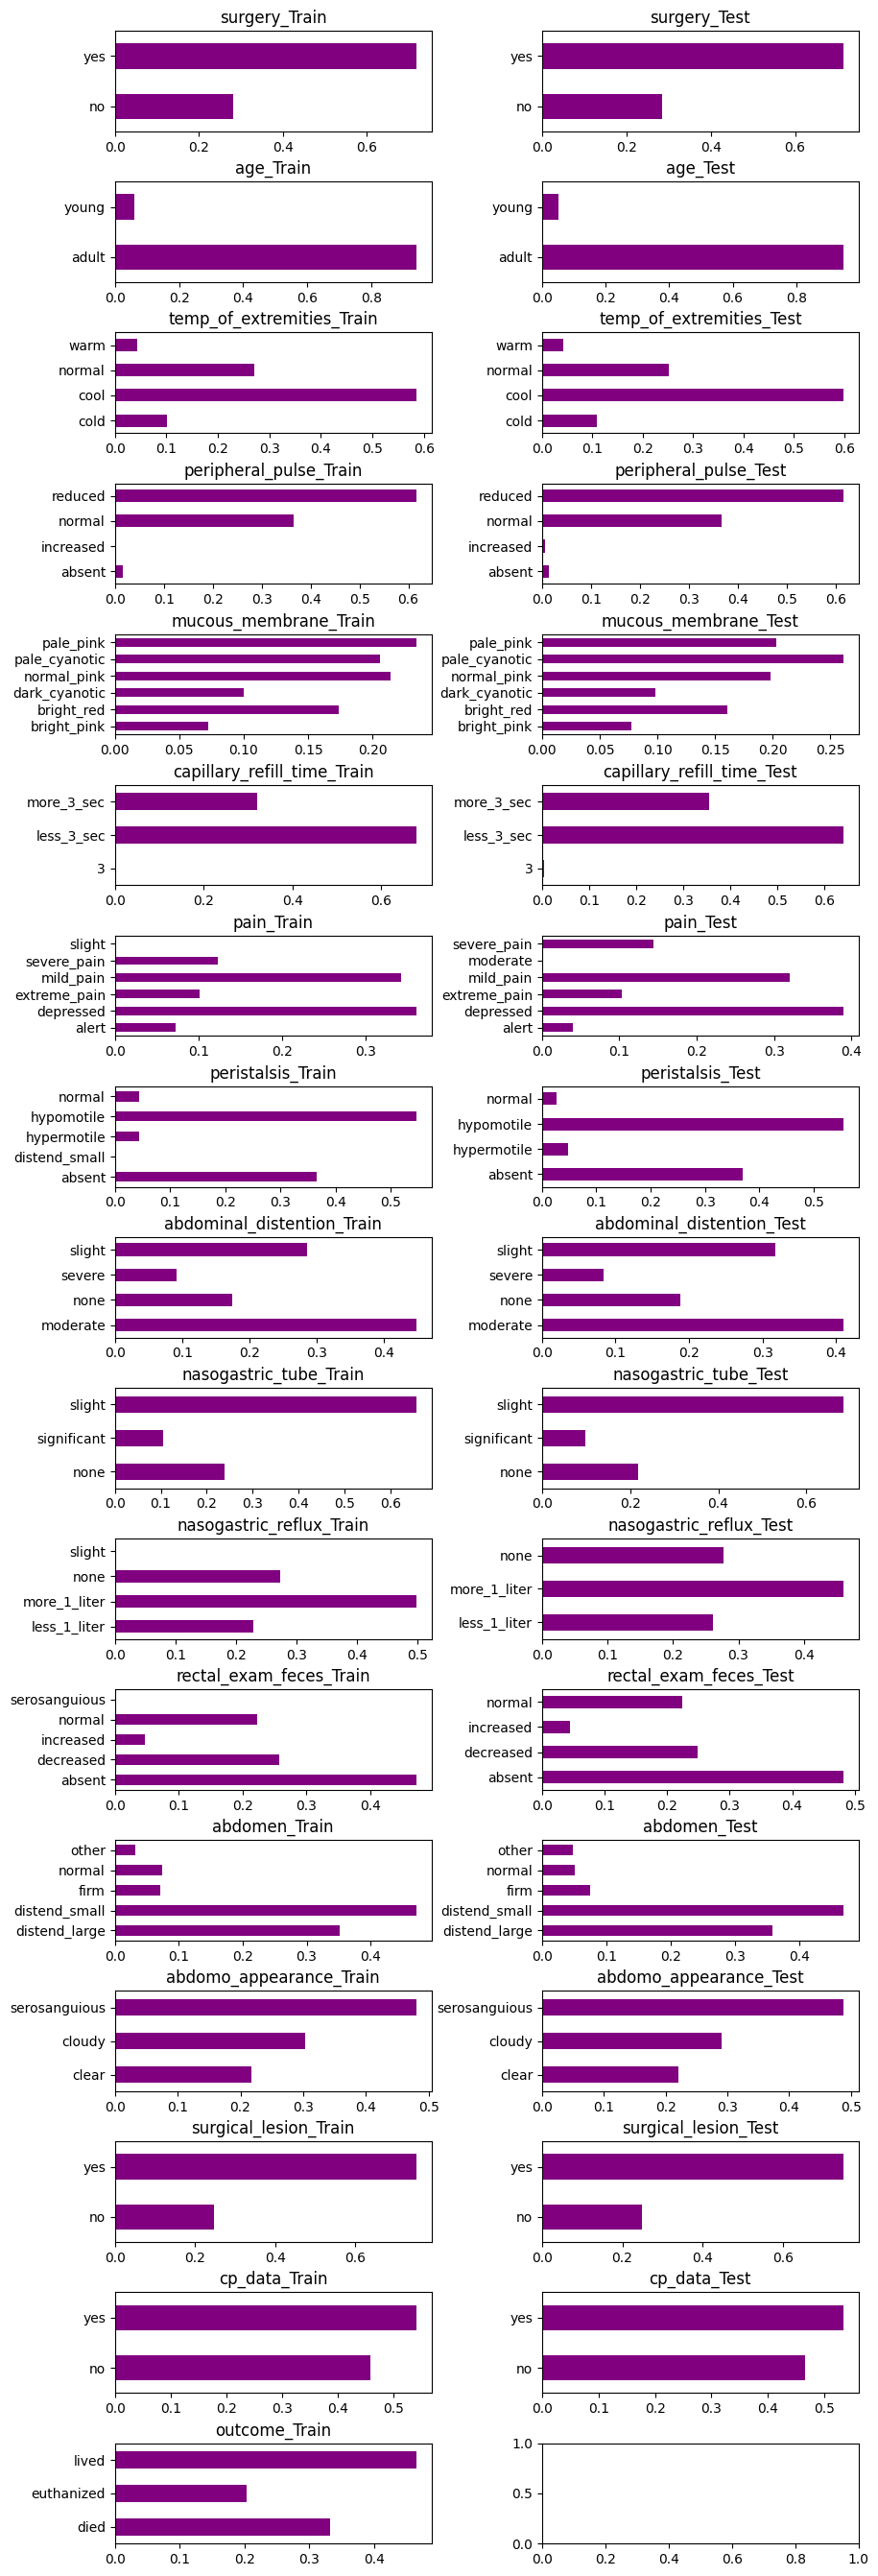

In [11]:
#单变量分布1
fig, axes = plt.subplots(len(cat_cols), 2, figsize = (10, len(cat_cols)* 2), 
                             gridspec_kw = {'wspace': 0.35, 'hspace': 0.5})
for i, column in enumerate(cat_cols):
    ax1 = axes[i, 0]
    ax2 = axes[i, 1]
    a = train_df[column].value_counts(normalize = True)
    a.sort_index().plot.barh(ax = ax1, color = 'purple')
    ax1.set_title(f"{column}_Train")
    ax1.set(ylabel = '')
    if column=='outcome':
        continue
    b = test_df[column].value_counts(normalize = True)
    b.sort_index().plot.barh(ax = ax2, color = 'purple')
    ax2.set_title(f"{column}_Test")
    ax2.set(ylabel = '')

## 1.pain  训练集slight  测试集moderate
##   考虑两者合并之后编码
## 2.peristalsis 训练集多一个distend_small（1个样本）
## 3.nasogastric_reflux 训练集多一个slight（1个样本）
## 4.rectal_exam_feces 训练集多一个serosanguious（1个样本）
##   234不删除可能也不影响，删除好像也不影响
## 5.mucous 中的pale_cyanotic分布不太一样（异常突出）
## 6.abdominal_distention、nasogastric_tube、nasogastric_reflux中的none   
##   考虑将None和none 都做none（普通字符串none的意义）处理？
##  （用isnull统计的None被视为无值，但是none被视为普通字符串）
##   此处处理完之后还需要做一下训练集和测试集分布分析


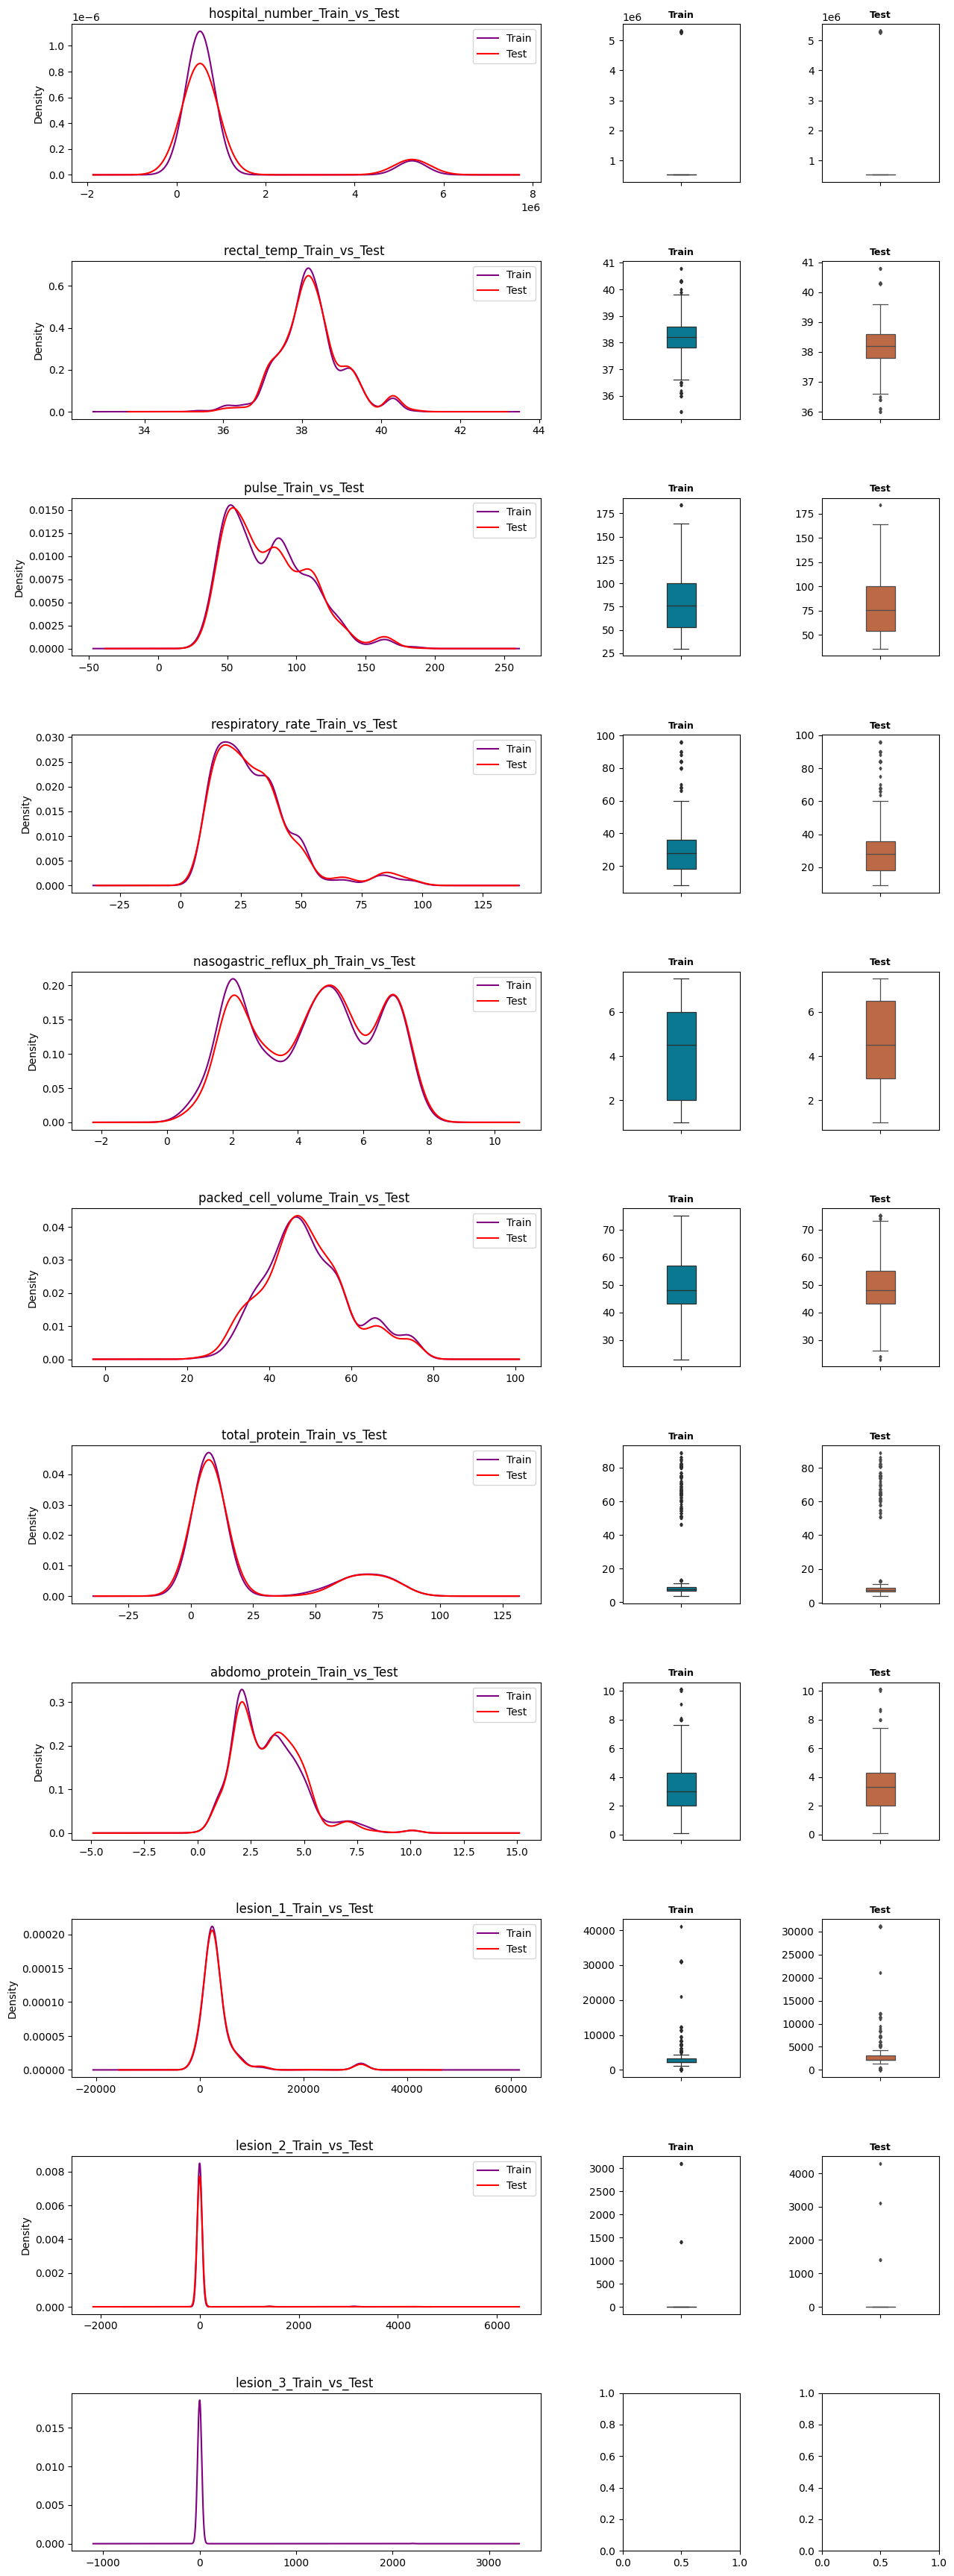

In [15]:
# 单变量分布
fig, axes = plt.subplots(len(num_cols), 3, figsize = (15, len(num_cols)* 4), 
                             gridspec_kw = {'wspace': 0.35, 'hspace': 0.5, 'width_ratios': [0.80, 0.20, 0.20]})
for i, column in enumerate(num_cols):
    ax = axes[i,0]
    a = train_df[column]
    a.plot(ax = ax,kind='density', color = 'purple',label='Train')
    ax.set_title(f"{column}_Train_vs_Test ")
    ax.set(ylabel = '')
    if column=='lesion_3':
        continue
    b = test_df[column]
    b.plot(ax = ax,kind='density', color = 'red',label='Test')
    ax.legend(['Train','Test'])
    ax = axes[i,1]
    sns.boxplot(y = a, width = 0.25,saturation = 0.90, linewidth = 0.90, fliersize= 2.25, color = '#037d97',ax = ax);
    ax.set(xlabel = '', ylabel = '');
    ax.set_title(f"Train",fontsize = 9, fontweight= 'bold');
    ax = axes[i,2];
    sns.boxplot(y = b, width = 0.25, fliersize= 2.25,saturation = 0.6, linewidth = 0.90, color = '#E4591E',ax = ax); 
    ax.set(xlabel = '', ylabel = '');
    ax.set_title(f"Test",fontsize = 9, fontweight= 'bold');
# 多变量分析

## 1.单变量分析，训练集和测试集分布基本一致，除了hospital_number和lesion_3差别
## 2.hospital_number
## 3.lesion_3

In [ ]:
# 联合outcome的单变量分布1
def plot_count(df,columns,n_cols,hue):
    '''
    # Function to genear countplot
    df: total data
    columns: category variables
    n_cols: num of cols
    '''
    n_rows = (len(columns) - 1) // n_cols + 1
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(17, 4 * n_rows))
    ax = ax.flatten()
    
    for i, column in enumerate(columns):
        sns.countplot(data=df, x=column, ax=ax[i],hue=hue)

        # Titles
        ax[i].set_title(f'{column} Counts', fontsize=18)
        ax[i].set_xlabel(None, fontsize=16)
        ax[i].set_ylabel(None, fontsize=16)
        ax[i].tick_params(axis='x', rotation=10)

        for p in ax[i].patches:
            value = int(p.get_height())
            ax[i].annotate(f'{value:.0f}', (p.get_x() + p.get_width() / 2, p.get_height()),
                           ha='center', va='bottom', fontsize=9)

    ylim_top = ax[i].get_ylim()[1]
    ax[i].set_ylim(top=ylim_top * 1.1)
    for i in range(len(columns), len(ax)):
        ax[i].axis('off')

    # fig.suptitle(plotname, fontsize=25, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
plot_count(train_df,cat_cols,3,'outcome')

In [ ]:
# 联合outcome的单变量分布2
plot_count(test_df,[cat_col for cat_col in cat_cols if cat_col != target],3,None)

In [ ]:
# 双变量配对分析
def plot_pair(df_train,num_var,target,plotname):
    '''
    Funtion to make a pairplot:
    df_train: total data
    num_var: a list of numeric variable
    target: target variable
    '''
    g = sns.pairplot(data=df_train, x_vars=num_var, y_vars=num_var, hue=target, corner=True)
    g._legend.set_bbox_to_anchor((0.8, 0.7))
    g._legend.set_title(target)
    g._legend.loc = 'upper center'
    g._legend.get_title().set_fontsize(14)
    for item in g._legend.get_texts():
        item.set_fontsize(14)

    plt.suptitle(plotname, ha='center', fontweight='bold', fontsize=25, y=0.98)
    plt.show()

plot_pair(train_df,num_cols,target,plotname = 'Scatter Matrix with Target')

In [ ]:
plt.figure(figsize=(15,15))
corr = train_df[num_cols].corr(method = "pearson")# 皮尔逊相关
mask = np.triu(np.triu(corr))
sns.heatmap(data = corr,annot=True, cmap = 'Blues', mask=mask)

## 1.pulse 和 respiratory_rate、packed_cell_volume正相关比较明显
## 2.nasogastric_reflux_ph 和total_protein、abdomo_protein分别呈负相关、正相关
## 3.total_protein和abdomo_protein呈正相关
## 4.lesion_2和lesion_3呈正相关

## 卡方检验

In [20]:
def chi_squared_test(df, input_var, target_var, significance_level=0.05):
    contingency_table = pd.crosstab(df[input_var], df[target_var])
    chi2, p, _, _ = stats.chi2_contingency(contingency_table)
    
    if p < significance_level:
        print(f'\033[32m{input_var} has a significant relationship with the target variable.\033[0m') 
    else:
        print(f'\033[31m{input_var} does not have a significant relationship with the target variable.\033[0m')  

for i in cat_cols:
    chi_squared_test(train_df, i, target)

surgery has a significant relationship with the target variable.
age has a significant relationship with the target variable.
temp_of_extremities has a significant relationship with the target variable.
peripheral_pulse has a significant relationship with the target variable.
mucous_membrane has a significant relationship with the target variable.
capillary_refill_time has a significant relationship with the target variable.
pain has a significant relationship with the target variable.
peristalsis has a significant relationship with the target variable.
abdominal_distention has a significant relationship with the target variable.
nasogastric_tube has a significant relationship with the target variable.
nasogastric_reflux has a significant relationship with the target variable.
rectal_exam_feces has a significant relationship with the target variable.
abdomen has a significant relationship with the target variable.
abdomo_appearance has a significant relationship with the target variabl

## **特征工程**

In [ ]:
## 1.通用组合特征
## 2.业务统计特征
## 我们需要融合？
## NLP特征池衍生（from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer）

## **pipeline**

In [ ]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="constant", fill_value="NaN")),
    ('encoder', OrdinalEncoder())
])
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols),
])
train_prepared = full_pipeline.fit_transform(train_df)
display(train_df)
display(pd.DataFrame(train_prepared))

# 或者单独处理？
# train_df[target] = train_df[target].map({'died':0,'euthanized':1,'lived':2})
# Encoding the categorical columns with domain based encoding:-
# 参考格式
# class Encoder(TransformerMixin, BaseEstimator):
#     """
#     This class is used to create encoded features from the existing object data
#     """; 
    
#     def __init__(self): pass;
    
#     def fit(self, X, y= None, **params):
#         self.ip_cols = X.columns;
#         return self;
    
#     def transform(self, X, y= None, **params):
#         """
#         This method performs manual label encoding for the category columns and lesion columns.
#         This is done as per the original data instructions- refer the original metadata page for details
#         """;
        
#         df = X.copy();
#         df['surgery'] = df['surgery'].map({'no': 1, 'yes': 0}).astype(np.int8);
#         df['age']     = df['age'].map({'adult': 0, 'young': 1}).astype(np.int8);
#         df['temp_of_extremities'] = \
#         df['temp_of_extremities'].map({'None': 0, "normal":1, "warm": 2, "cool":3, "cold":4}).astype(np.int8);
#         df['peripheral_pulse'] = \
#         df['peripheral_pulse'].map({'NA': 0, "None": 0, 
#                                       "normal":1, "increased": 2, "reduced":3, "absent":4}
#                                   ).astype(np.int8);
#         df['mucous_membrane'] = \
#         df['mucous_membrane'].map({'NA': 0, "None": 0, "normal":1, "normal_pink":1, "pink": 2, "bright" : 3,
#                                      "bright_pink":3, "pale_pink":4 , "pale_cyanotic": 5, 
#                                      "bright_red":6, "injected": 6, "dark_cyanotic": 7
#                                     }
#                                  ).astype(np.int8);
#         df['capillary_refill_time'] = \
#         df['capillary_refill_time'].map({'NA': 0, "None": 0, "less_3_sec":1, "3": 2, "more_3_sec": 2}).astype(np.int8); 
#         df['pain'] = \
#         df['pain'].map({"NA": 0, "None": 0, "alert" : 1, "no_pain": 2, "depressed": 3, 
#                         "mild_pain": 4, 'slight': 3, "moderate": 4, "severe_pain": 5, "extreme_pain": 6
#                        }
#                       ).astype(np.int8);
#         df['peristalsis'] = \
#         df['peristalsis'].map({"NA": 0, "None": 0, "hypermotile": 1, 'distend_small':1, 
#                                "normal": 2,"hypomotile": 3, "absent": 4}
#                              ).astype(np.int8);
#         df['abdominal_distention'] = \
#         df['abdominal_distention'].map({"NA": 0, "none": 1, "slight": 2, "moderate": 3, "severe": 4}).astype(np.int8);
#         df['nasogastric_tube'] = \
#         df['nasogastric_tube'].map({"NA": 0, "none": 1, "slight": 2, "significant": 3}).astype(np.int8);
#         df['nasogastric_reflux'] = \
#         df['nasogastric_reflux'].map({"NA": 0, "none": 1, 'slight':2, "less_1_liter": 2, "more_1_liter": 3}).astype(np.int8);
#         df['rectal_exam_feces'] = \
#         df['rectal_exam_feces'].map({"NA": 0, "None": 0, 
#                                      "normal": 1, "increased": 3, "decreased": 4, "absent": 5, 'serosanguious':6}
#                                    ).astype(np.int8);
#         df['abdomen'] = \
#         df['abdomen'].map({"NA": 0, "None":0, 
#                            "normal": 1, "other": 2, "firm": 3, "distend_small": 4, "distend_large": 5}
#                          ).astype(np.int8);
#         df['abdomo_appearance'] = \
#         df['abdomo_appearance'].map({"NA": 0, "None":0,"clear": 1, "cloudy": 2, "serosanguious": 3}).astype(np.int8);
#         df['surgical_lesion'] = df['surgical_lesion'].map({"no": 1, "yes": 0}).astype(np.int8);
#         df['cp_data'] = df['cp_data'].map({"no": 1, "yes": 0}).astype(np.int8);
        
#         #  Encoding the lesion 2 as 0/ non-zero:-
#         df['lesion_2'] = df['lesion_2'].clip(0, 1).astype(np.int8);
        
#         df[['hospital_number', 'lesion_1', 'pain']] = \
#         df[['hospital_number', 'lesion_1', 'pain']].astype(int);
                  
#         self.op_cols = df.columns; 
#         return df;
    
#     def get_feature_names_in(self, X, y=None, **params): 
#         return self.ip_cols;    
    
#     def get_feature_names_out(self, X, y=None, **params): 
#         return self.op_cols;  
# Scaling:-
# class Scaler(TransformerMixin, BaseEstimator):
#     """
#     This class aims to create scaling for the provided dataset
#     """;
    
#     def __init__(self, scl_method: str, scale_req: str, scl_cols):
#         self.scl_method = scl_method;
#         self.scale_req  = scale_req;
#         self.scl_cols   = scl_cols;
        
#     def fit(self,X, y=None, **params):
#         "This function calculates the train-set parameters for scaling";
        
#         self.params          = X[self.scl_cols].describe(percentiles = [0.25, 0.50, 0.75]).drop(['count'], axis=0).T;
#         self.params['iqr']   = self.params['75%'] - self.params['25%'];
#         self.params['range'] = self.params['max'] - self.params['min'];
        
#         return self;
    
#     def transform(self,X, y=None, **params):  
#         "This function transform the relevant scaling columns";
        
#         df = X.copy();
#         if self.scale_req == "Y":
#             if CFG.scl_method == "Z":
#                 df[self.scl_cols] = (df[self.scl_cols].values - self.params['mean'].values) / self.params['std'].values;
#             elif CFG.scl_method == "Robust":
#                 df[self.scl_cols] = (df[self.scl_cols].values - self.params['50%'].values) / self.params['iqr'].values;
#             elif CFG.scl_method == "MinMax":
#                 df[self.scl_cols] = (df[self.scl_cols].values - self.params['min'].values) / self.params['range'].values;
#         else:
#             PrintColor(f"Scaling is not needed", color = Fore.RED);
    
#         return df;

## Pipline后分析

In [ ]:
## 信息增益，互信息
def make_mi_scores(X, y):
    mi_scores = mutual_info_classif(X, y)
    columns = full_pipeline.get_feature_names_out()
    columns = np.delete(columns, len(columns) - 1)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

X = train_prepared[:, :-1].copy()
y = train_prepared[:, -1]

mi_scores = make_mi_scores(X, y)
display(mi_scores[::3]) # show a few features with their MI scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [ ]:
sns.kdeplot(data=train_df, x='hospital_number', hue='outcome', fill=True)
plt.title("Distribution of hospital_number, by outcome")

## PCA分析

In [ ]:
train_X = train_prepared[:, :-1]
train_y = train_prepared[:, -1]
pca = PCA(n_components = 10)
X2D = pca.fit_transform(train_X)
display(pd.DataFrame(X2D))
display(pd.DataFrame(pca.explained_variance_ratio_))

## 网格搜索相关

In [ ]:
# # Pipeline specifics:-
# from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler;
# from sklearn.impute import SimpleImputer as SI;
# from sklearn.model_selection import (RepeatedStratifiedKFold as RSKF, 
#                                      StratifiedKFold as SKF,
#                                      KFold, 
#                                      RepeatedKFold as RKF, 
#                                      cross_val_score);
# from sklearn.inspection import permutation_importance;
# from sklearn.feature_selection import mutual_info_classif, RFE;
# from sklearn.pipeline import Pipeline, make_pipeline;
# from sklearn.base import BaseEstimator, TransformerMixin;
# from sklearn.compose import ColumnTransformer;

# # ML Model training:-
# from sklearn.metrics import f1_score, confusion_matrix, make_scorer;
# from xgboost import DMatrix, XGBClassifier;
# from lightgbm import LGBMClassifier, log_evaluation, early_stopping;
# from catboost import CatBoostClassifier, Pool;
# from sklearn.ensemble import (RandomForestClassifier as RFC, 
#                               ExtraTreesClassifier as ETC,
#                               AdaBoostClassifier as ABC,
#                               BaggingClassifier as BC,
#                               HistGradientBoostingClassifier as HGBC
#                              );
# from sklearn.linear_model import LogisticRegression as LC;
# Mdl_Master = \
# {'CBC': CatBoostClassifier(**{'task_type'           : "GPU" if CFG.gpu_switch == "ON" else "CPU",
#                               'objective'           : "MultiClass",
#                               'eval_metric'         : "Accuracy",
#                               'classes_count'       : 3,
#                               'bagging_temperature' : 0.10,
#                               'colsample_bylevel'   : 0.75,
#                               'iterations'          : 1000,
#                               'learning_rate'       : 0.075,
#                               'od_wait'             : 3,
#                               'max_depth'           : 4,
#                               'l2_leaf_reg'         : 0.85,
#                               'min_data_in_leaf'    : 6,
#                               'random_strength'     : 0.65, 
#                               'max_bin'             : 80,
#                               'verbose'             : 0,
#                               'use_best_model'      : True,
#                            }
#                          ), 

#   'LGBMC': LGBMClassifier(**{'device'            : "gpu" if CFG.gpu_switch == "ON" else "cpu",
#                              'objective'         : 'multiclass',
#                              'metric'            : 'none',
#                              'boosting_type'     : 'gbdt',
#                              'random_state'      : CFG.state,
#                              'colsample_bytree'  : 0.5,
#                              'subsample'         : 0.65,
#                              'learning_rate'     : 0.08,
#                              'max_depth'         : 4,
#                              'n_estimators'      : 1000,
#                              'num_leaves'        : 72,                    
#                              'reg_alpha'         : 0.01,
#                              'reg_lambda'        : 1.75,
#                              'verbose'           : -1,
#                          }
#                       ),

#   'XGBC': XGBClassifier(**{'tree_method'        : "gpu_hist" if CFG.gpu_switch == "ON" else "hist",
#                            'objective'          : 'multi:softprob',
#                            'random_state'       : CFG.state,
#                            'colsample_bytree'   : 0.7,
#                            'learning_rate'      : 0.07,
#                            'max_depth'          : 4,
#                            'n_estimators'       : 1100,                         
#                            'reg_alpha'          : 0.025,
#                            'reg_lambda'         : 1.75,
#                            'min_child_weight'   : 5,
#                            'early_stopping_rounds' : CFG.nbrnd_erly_stp,
#                         }
#                        ),
 
#    'RFC' : RFC(n_estimators     = 150, 
#                criterion        = 'gini',
#                max_depth        = 4,
#                min_samples_leaf = 5,
#                max_features     = 'log2',
#                bootstrap        = True,
#                oob_score        = True,
#                random_state     = CFG.state,
#                verbose          =0,
#               ), 
 
#   "HGBC" : HGBC(loss              = 'categorical_crossentropy',
#                 learning_rate     = 0.075,
#                 early_stopping    = True,
#                 max_iter          = 200,
#                 max_depth         = 4,
#                 min_samples_leaf  = 5,
#                 l2_regularization = 1.75,
#                 scoring           = myscorer,
#                 random_state      = CFG.state,
#                )
# };

## 单模型----> 随机森林、LightGBM、XGBoost、CatBoost

## 均值融合、加权融合、Stacking融合(分类问题用逻辑回归、否则用贝叶斯回归(bayesianRidge))

## trick